<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning visualisations v2: Weight Visualisations
This notebook explores the possibilities for visualising the trained weights. The intent is to create some re-usable libraries that I can use on more advanced networks to help understand what they're doing. And in the process, learn some stuff.

The initial use case I've chosen is on an image classification task. Initial classification code based on tutorial: https://www.tensorflow.org/tutorials/keras/classification.

There are a few weight visualisations to explore:
* **Basic Info**: In order to understand the problems, I've done some basic plots of the weights themselves. This looks like a useful thing to turn into a generic "summarise" tool.
* **Feature strengths**: Some features are less important than others. There's a few logical steps of improvements possible here.
  * **1)** To measure this, run across the data set and look at the stddev of outputs from each of the features at a given layer. We can plot that to identify which features are more significant than others.
  * **2)** However, that alone isn't quite accurate, because it depends more on how those features are later used, and they may be disproportionately scalled by the subsequent layer. So, now use the next layer, takes its weights against feature, average them, use those averaged weights to scale the stddevs, and plot again. Now we have quite a realistic measure of the relative importance of different features.
  * **3)** Note that this too is just a "shallow" measure. The most accurate measure would be to look at how each individual feature affects the final output - calculating $\frac{do}{df}$ (delta in output w.r.t. the feature). Interestingly, that's just the gradient that's calculated during training. So, to calculate it we'd just want to grab the average gradient across the training set, once in a training state.
* **Curve**: Examine the interpretation of the weights+biases+relu activation in a single layer against a single input to construct a single non-linear curve.
* **Areas of interest (images only)**: by examining the magnitude of weights against different parts of the input image, we should see differences in the "areas of interest". There are two versions of this that both look at the differences in magnitude across the image:
  * **a)** larger vs smaller average weight magnitude for a given pixel
  * **b)** larger vs smaller stddev of weights for a given pixel
  * Note that the same actually applies to non-images, but it's easier to understand in terms of images, particularly because they have such a large input feature size.
* **Reverse Image Construction (images only)**: illustrate what different nodes look for by constructing input images that maximise the output of a given node.

Further thoughts...

**Curve:** There are further things to think about. For example, the current approach is perhaps naive and resource intensive, whereas there may be a more direct way of extracting what I want directly from the weight matrix using a little bit of maths.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0


In [ ]:
# First, some helper methods
def plot_fit(model, x, history = None):
  y_predict = model.predict(x)

  x_wide = np.linspace(-100, 200, 1000)
  y_wide_predict = model.predict(x_wide)

  pnum = 2
  if history != None:
    pnum += 1

  plt.figure(layout='constrained')
  plt.subplot(1,pnum,1)
  plt.plot(x,y, color='blue', label="Truth")
  plt.plot(x,y_predict, color='orange',label="Prediction")
  plt.legend()
  plt.subplot(1,pnum,2)
  plt.plot(x_wide,y_wide_predict, color='orange', label="Prediction")
  plt.legend()
  if history != None:
    plt.subplot(1,pnum,3)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_interval == 0:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f"train_images shape: {train_images.shape}")
print(f"train_labels shape: {train_labels.shape}")

4422102/4422102 [==============================] - 0s 0us/step
train_images shape: (60000, 28, 28)
train_labels shape: (60000,)


In [ ]:
# pre-process into the correct data range
train_images = train_images / 255.0
test_images = test_images / 255.0

Show an example image:

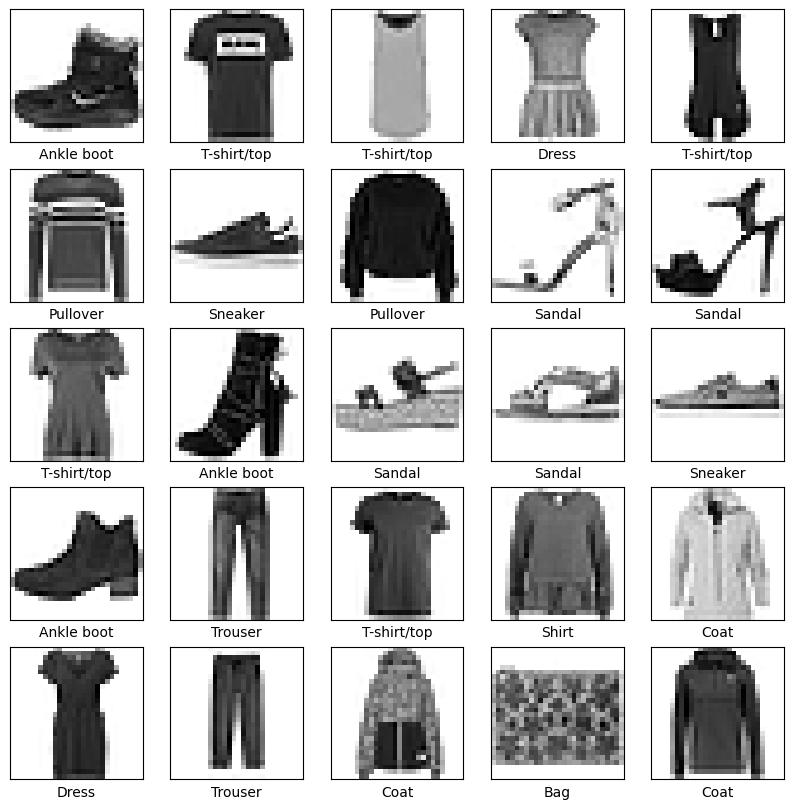

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [ ]:
# Let's understand the range of data values.
min_value = np.min(train_images)
max_value = np.max(train_images)
min_values = np.min(train_images, axis=0)
max_values = np.max(train_images, axis=0)
default_value = np.mean(train_images)
default_values = np.mean(train_images, axis=0)
print(f"min value     : {min_value}")
print(f"max value     : {max_value}")
print(f"mean value    : {np.mean(train_images)}")
print(f"stddev        : {np.std(train_images)}")
print(f"default value : {default_value}")
print(f"default values: shape {default_values.shape}")

min value     : 0.0
max value     : 1.0
mean value    : 0.2860405969887955
stddev        : 0.35302424451492237
default value : 0.2860405969887955
default values: shape (28, 28)


## Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10)
mnist_model = model

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4978 - accuracy: 0.8241
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3764 - accuracy: 0.8651
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3375 - accuracy: 0.8757
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3117 - accuracy: 0.8853
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2952 - accuracy: 0.8912
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2809 - accuracy: 0.8951
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2678 - accuracy: 0.8999
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2587 - accuracy: 0.9040
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2472 - accuracy: 0.9085
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.238

In [ ]:
# Let's examine the shape of the weights
model = mnist_model
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               100480    
                                                                 
 dense_35 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
weights = model.get_layer(index=1).variables[0].numpy()
bias    = model.get_layer(index=1).variables[1].numpy()
print(f"weights shape: {weights.shape}")
print(f"bias    shape: {bias.shape}")

weights shape: (784, 128)
bias    shape: (128,)


## Let's first understand the raw weights

(array([ 3.,  1.,  8.,  8., 27., 24., 19., 18., 12.,  8.]),
 array([-0.60674763, -0.46905923, -0.33137083, -0.19368245, -0.05599406,
         0.08169433,  0.21938273,  0.35707113,  0.4947595 ,  0.6324479 ,
         0.7701363 ]),
 <BarContainer object of 10 artists>)

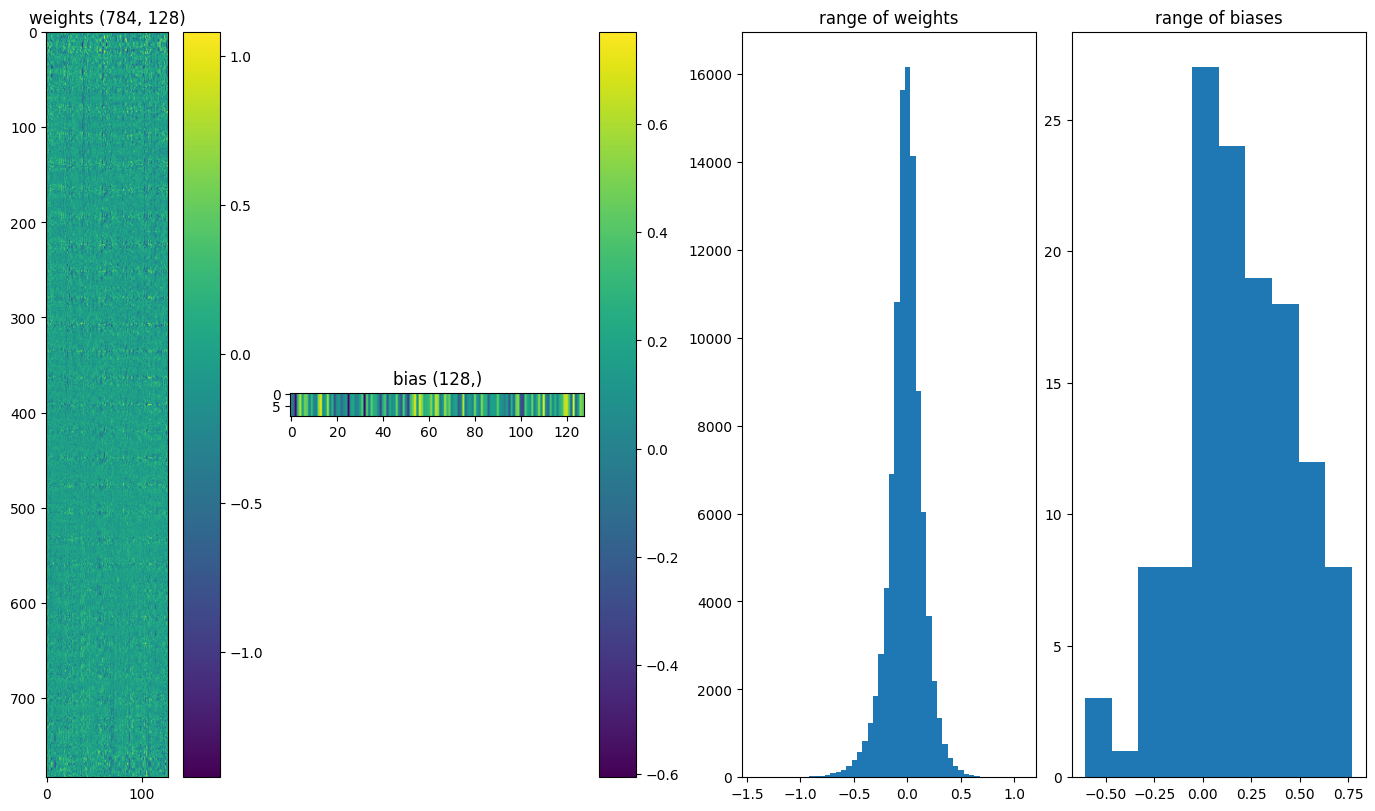

In [ ]:
plt.figure(figsize=(15,8), layout='constrained')
plt.subplot(1,4,1)
plt.title(f"weights {weights.shape}")
plt.imshow(weights)
plt.colorbar()
plt.subplot(1,4,2)
plt.title(f"bias {bias.shape}")
plt.imshow(np.tile(bias,(10,1)))
plt.colorbar()
plt.subplot(1,4,3)
plt.title("range of weights")
plt.hist(weights.reshape(-1,1),bins=50)
plt.subplot(1,4,4)
plt.title("range of biases")
plt.hist(bias,bins=10)

Let's try to understand how those weights relate back to the input images.

In the first layer there are 128 features. For each feature independently, some of the input pixels will be more interesting than others. This should be indicated by having greater weights. Given that there's only 128 features, let's just plot those weights as input images against each feature:

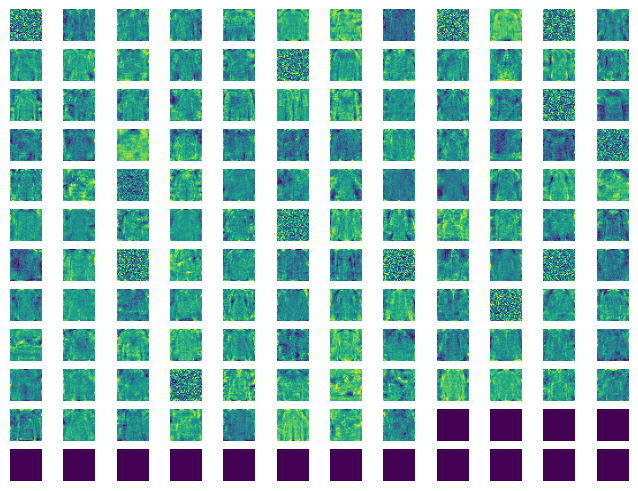

In [ ]:
# note that in the figure, the weight images are all automatically scaled to their individual min/max ranges
fig = plt.figure(layout='constrained')
axs = fig.subplots(12,12)
idx = 0
for row in range(12):
  for col in range(12):
    if idx < 128:
      img = weights[:,idx].reshape(28,28)
    else:
      img = np.zeros((28,28))
    axs[row,col].imshow(img)
    axs[row,col].set_axis_off()
    idx += 1

These are effectively heatmaps of weights.
Notice that each image is automatically and independently scaled by matplotlib. That's good because, without further information from other parts of the model, weights across different features are not on comparable scales.

Now, if we average across these scaled images, we'll get one image that represents the relative interest across each input image pixel:

feature_min shape: (128,)
feature_max shape: (128,)
interest_image shape: (28, 28)


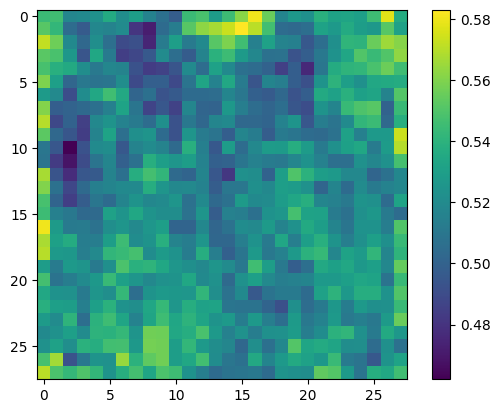

In [ ]:
feature_min = np.min(weights,axis=0)
feature_max = np.max(weights,axis=0)
print(f"feature_min shape: {feature_min.shape}")
print(f"feature_max shape: {feature_max.shape}")
normalised_weights = (weights - feature_min) / (feature_max - feature_min)
interest_image = np.mean(normalised_weights,axis=1).reshape(28,28)
print(f"interest_image shape: {interest_image.shape}")

plt.figure()
plt.imshow(interest_image)
plt.colorbar()

To be even more precise, we need to consider that some features at this first layer are more significant than others. We can only find that out by looking at the next layer.
So let's get that information and plot the list of features again, but this time scaled by their relative importance for the next layer:

output layer weights shape: (128, 10)
feature strengths shape: (128,)


(array([44., 49., 22., 10.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.07308158, 0.18019818, 0.2873148 , 0.39443141, 0.50154799,
        0.60866463, 0.71578121, 0.82289785, 0.93001443, 1.03713107,
        1.14424765]),
 <BarContainer object of 10 artists>)

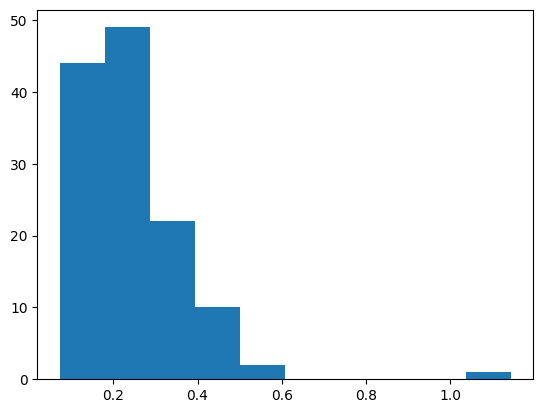

In [ ]:
# here I'll use "feature strengths" to refer to the relative weighting applied to each of the 128 features in the first layer
# (using "strengths" to avoid overloading "weights" term already in use)
outlayer_weights = model.get_layer(index=2).variables[0].numpy()
print(f"output layer weights shape: {outlayer_weights.shape}")
feature_strengths = np.mean(np.abs(outlayer_weights),axis=1)
print(f"feature strengths shape: {feature_strengths.shape}")
plt.figure()
plt.hist(feature_strengths)

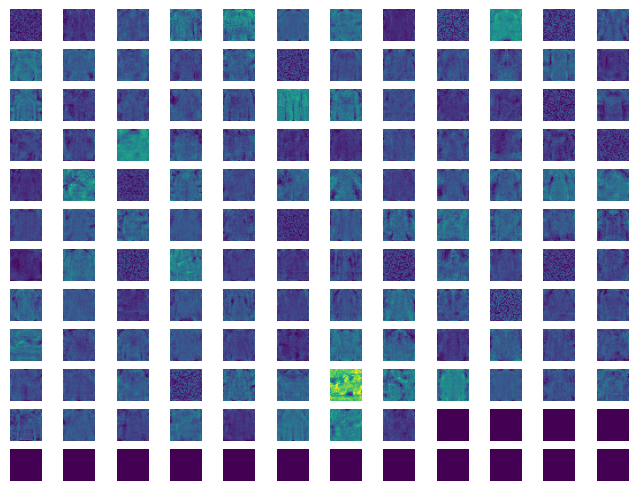

In [ ]:
# Re-using 'normalised_weights' computed above and forcing matplotlib to use the same scale
# We'll apply feature_strengths, but modified by sqrt() because a lot of the values are close to zero and it's harder to see the features
fig = plt.figure(layout='constrained')
axs = fig.subplots(12,12)
idx = 0
for row in range(12):
  for col in range(12):
    if idx < 128:
      img = normalised_weights[:,idx].reshape(28,28) * math.sqrt(feature_strengths[idx])
    else:
      img = np.zeros((28,28))
    axs[row,col].imshow(img, vmin=0.0, vmax=1.0)
    axs[row,col].set_axis_off()
    idx += 1

Indices of pixels with largest weight/bias ratio: [681 307  70 708  28 680 709  41  44 737 476 448  16  42  43 756]


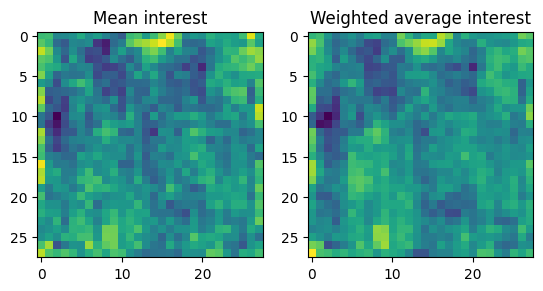

In [ ]:
# Generating the single image
interest_image1 = np.mean(normalised_weights,axis=1).reshape(28,28)
interest_image2 = np.mean(normalised_weights * feature_strengths,axis=1).reshape(28,28)

plt.figure()
plt.subplot(1,2,1)
plt.title("Mean interest")
plt.imshow(interest_image1)
plt.subplot(1,2,2)
plt.title("Weighted average interest")
plt.imshow(interest_image2)

# Pixel indices with greatest effect (against flattened shape)
greatest_effect_indices = interest_image2.reshape(-1).argsort()[-16:]
print(f"Indices of pixels with largest weight/bias ratio: {greatest_effect_indices}")

## Simple weight plotting

In [ ]:
## Simple weight plotting
x0 = np.linspace(min_value, max_value, 100)
sim_images = np.full((len(x0),28,28), default_value)
sim_images[:,15,15] = x0

In [ ]:
sim_images.shape

(100, 28, 28)

In [ ]:
sim_images[:,15,15]

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

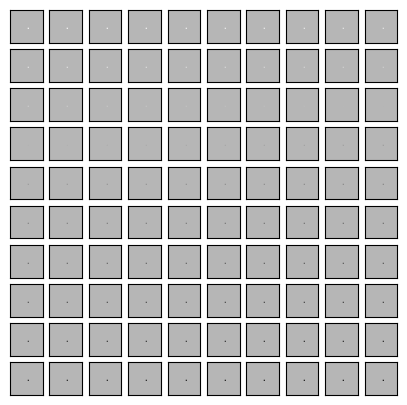

In [ ]:
plt.figure(figsize=(5,5))
for i in range(len(x0)):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sim_images[i], cmap=plt.cm.binary, vmin=0, vmax=1.0)
plt.show()

In [ ]:
inputs = sim_images.reshape(-1,28*28)
outputs = np.matmul(inputs, weights) + bias
outputs = np.maximum(0, outputs)
value = np.sum(outputs, axis=1)
print(f"outputs.shape: {outputs.shape}")
print(f"value.shape:   {value.shape}")

outputs.shape: (100, 128)
value.shape:   (100,)


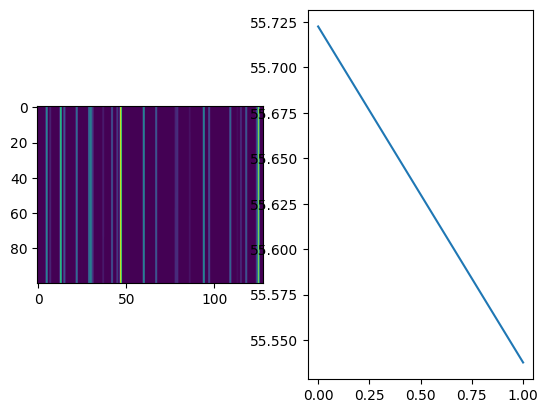

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(outputs)
plt.subplot(1,2,2)
plt.plot(x0, value)

**Commentary:**
* Weighted average for true curve:
   * To get the most accurate results I'd now pass these output activations into a node in the next layer so that it's different weights against these different outputs can be applied. Only then do you see the curve that the model is actually consuming internally. However, that creates a multivariate effect which makes it harder to pick a small number of visualisations. Also, because this plot is show boring, adding different weights isn't going to change anything much.
* $(x0,x1)$
  * I had considered plotting 2D heatmaps to optimise by showing 2 variables together at the same time. This should also provide interesting results. However, given a 28x28 image, there's too many different possible combinations, so it's better in this case to plot each pixel-variable independently. That way I've only got 28x28 plots to show.
* Boring
  * This plot is too boring to continue with next steps on its own. So I'll focus on generating a grid of such plots so I can find something interesting to look at.

## Multi-plot

In [ ]:
def get_output_curve(layer, coord, values, default_values, **kwargs):
  """
  Computes the output activations and summed curve for the range of values applied to the given coordinate.
  Generates synthetic layer inputs with default_values for all cells except for the given 'coord', which is
  given the supplied range of values.
  Args:
    layer                  : assumed to be a Dense layer
    coord  (int)           : coordinate to apply values, according to input shape of layer
    values (ndarray (v,))  : a range of input values to try against the coordinate (v values)
    default_values (scalar or ndarray (n,)) :
                             default value or values for all other input cells (n inputs).
                             Either a scalar, or an array of same size as input vector.
  Keyword args:
    node_scaling (ndarray (j,)): relative importance of each node's output,
                                 used to calculate the curve via a weighted sum instead of an equal sum
  Returns
    curve       (ndarray (v,))
    activations (ndarray (v,j)) : activations from each node in the layer (j nodes)
  """
  if not isinstance(layer, tf.keras.layers.Dense):
    raise Exception(f"Not a supported layer type: {type(layer)}")
  if not np.isscalar(coord):
    raise Exception(f"Coord must be an integer scalar")

  weights = layer.variables[0].numpy()
  bias    = layer.variables[1].numpy()
  in_width  = weights.shape[0]
  out_width = weights.shape[1]
  #print(f"weights shape: {weights.shape}")
  #print(f"bias    shape: {bias.shape}")

  node_scaling = kwargs.get('node_scaling', np.repeat(1., out_width))

  if coord < 0 or coord >= in_width:
    raise Exception(f"Coord must be in range [0,{in_width}): {coord}")
  if not np.isscalar(default_values) and default_values.shape != (in_width,):
    raise Exception(f"default_values must be either scalar or have shape ({in_width},): {default_values.shape}")
  if node_scaling.shape != (out_width,):
    raise Exception(f"node_scaling must have shape ({out_width},): {node_scaling.shape}")

  input = np.full((len(values), in_width), default_values)
  input[:,coord] = values

  outputs = np.matmul(input, weights) + bias
  outputs = np.maximum(0, outputs)              # TODO apply activation function from layer config
  outputs = outputs * node_scaling
  curve = np.sum(outputs, axis=1)
  #print(f"activation.shape: {outputs.shape}")
  #print(f"curve.shape:      {value.shape}")

  return (curve, outputs, input)

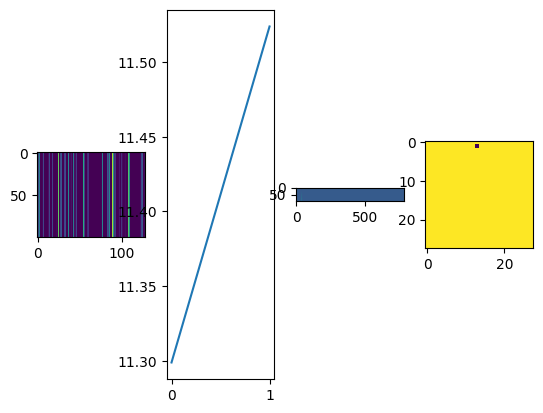

In [ ]:
# largest weight indices: 511  43  28 681 728 509 757  69  70  16 392  56  42  29  41 756
coord = 41
v = np.linspace(min_value, max_value, 100)
(c, a, inp) = get_output_curve(model.get_layer(index=1), coord, v, default_value, node_scaling=feature_strengths)

plt.figure()
plt.subplot(1,4,1)
plt.imshow(a)
plt.subplot(1,4,2)
plt.plot(v, c)
plt.subplot(1,4,3)
plt.imshow(inp)
plt.subplot(1,4,4)
plt.imshow(inp[0].reshape(28,28))

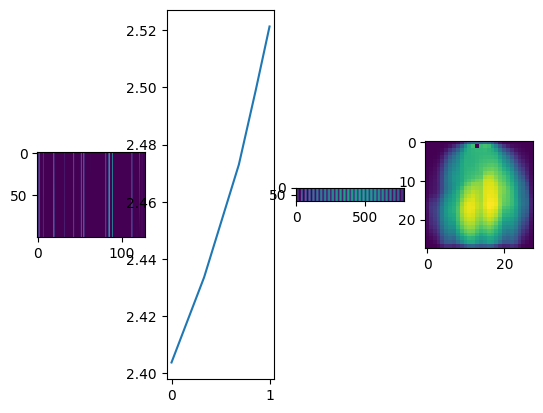

In [ ]:
# same as above but setting to per-pixel means
v = np.linspace(min_value, max_value, 100)
(c, a, inp) = get_output_curve(model.get_layer(index=1), coord, v, default_values.reshape(-1), node_scaling=feature_strengths)

plt.figure()
plt.subplot(1,4,1)
plt.imshow(a)
plt.subplot(1,4,2)
plt.plot(v, c)
plt.subplot(1,4,3)
plt.imshow(inp)
plt.subplot(1,4,4)
plt.imshow(inp[0].reshape(28,28))

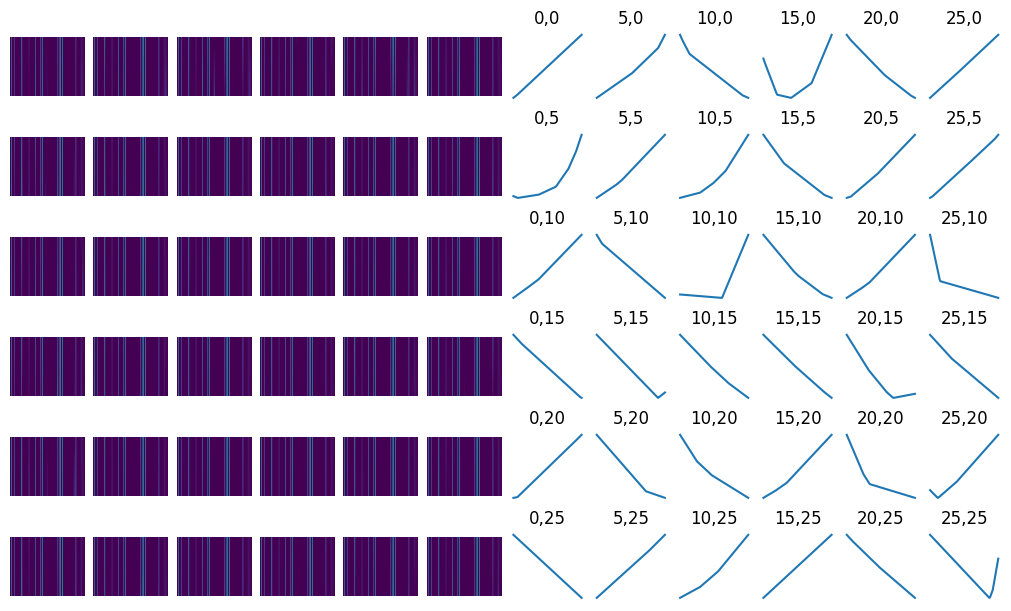

In [ ]:
# Iterate over a number of coords chosen on a grid pattern and plot all the results
# Tip: experiment using default_value or default_values.
model = mnist_model
layer = model.get_layer(index=1)
values = np.linspace(min_value, max_value, 100)
results = list()
for y in range(0,28,5):
  for x in range(0,28,5):
    #print(f"({x},{y}) -> {y*28+x}")
    #(c, a, _) = get_output_curve(layer, y*28+x, values, default_value)
    (c, a, _) = get_output_curve(layer, y*28+x, values, default_values.reshape(-1))
    results.append({
        "x": x,
        "y": y,
        "c": c,
        "a": a
    })

fig = plt.figure(figsize=(10,6), layout='constrained')
axs = fig.subplots(6,12)
for row in range(6):
  for col in range(6):
    idx = row*6+col
    res = results[idx]
    axs[row,col].imshow(res["a"])
    axs[row,col].set_axis_off()
    axs[row,col+6].plot(values, res["c"])
    axs[row,col+6].set_axis_off()
    axs[row,col+6].set_title(f"{res['x']},{res['y']}")

Plotting: 4 x 4


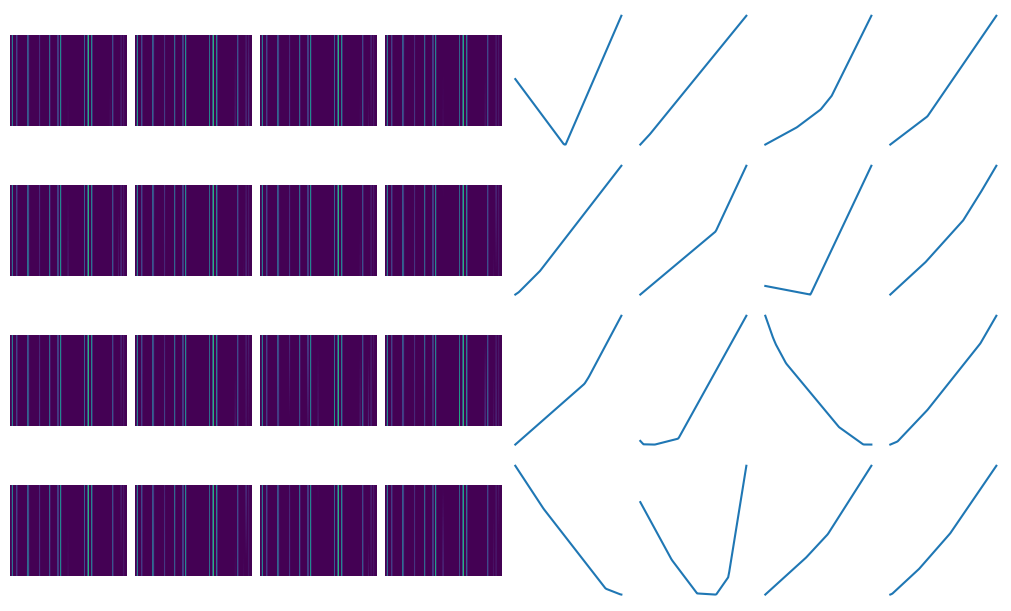

In [ ]:
# Iterate over a number of coords and plot all the results
# - this time using the most effective pixels:
# Tip: experiment using default_value or default_values.
layer = model.get_layer(index=1)
values = np.linspace(min_value, max_value, 100)
results = list()
for idx in greatest_effect_indices:
  #(c, a, _) = get_output_curve(layer, idx, values, default_value)
  (c, a, _) = get_output_curve(layer, idx, values, default_values.reshape(-1))
  results.append({
      "x": x,
      "y": y,
      "c": c,
      "a": a
  })

fig = plt.figure(figsize=(10,6), layout='constrained')
cols = math.floor(math.sqrt(len(results)))
rows = math.ceil(len(results)/cols)
print(f"Plotting: {rows} x {cols}")
axs = fig.subplots(rows,cols*2)
idx = 0
for row in range(rows):
  for col in range(cols):
    if idx < len(results):
      res = results[idx]
    else:
      res = {
          "a": np.zeros(2,2),
          "c": np.zeros(len(values),)
      }
    res = results[idx]
    axs[row,col].imshow(res["a"])
    axs[row,col].set_axis_off()
    axs[row,col+cols].plot(values, res["c"])
    axs[row,col+cols].set_axis_off()
    idx += 1

**Learnings so far:**
* **Success**: I'm finally starting to get some curves. In fact, I'm seeing interesting curves against randomly chosen image pixels and when targeting the pixels with the strongeth effects, and I'm not seeing much difference in the forms of the results. That's promising for the possibility of creating an automated package for this visualisation.
* **Simple**: The curves are all very simple. It's no wonder that KNNs use simple splines to represent weights and get just as good results with significantly less weights. We're really not getting the full benefit of our weights.
* **Curse of averages**: One of the problems I've realised is that a single pixel is just one in 748 weights. So it's effect gets averaged out to nothing. This is probably the biggest reason why I'm getting such simple curves across 128 nodes. They look like they've only got about 3 nodes constructing them. The reality is that those 128 nodes represent a very complex combination of something like 748! (factorial) different curves.

Next steps:
* At this point, it's perhaps worth re-scaling the curves according to `feature_strengths`. It's clear from the apparent uniformity of the activation plots that there's large unchanging values that are taking the largest effect. It's possible that the relative feature_strengths will reduce that skew.
* It would also be interesting to just uniformly scale all pixels instead of changing just one. The problem is that any curves produced aren't really representative of anything real - they're represntative of what happens if we lock all pixels together - which doesn't happen in reality. But we might get more interesting curves.

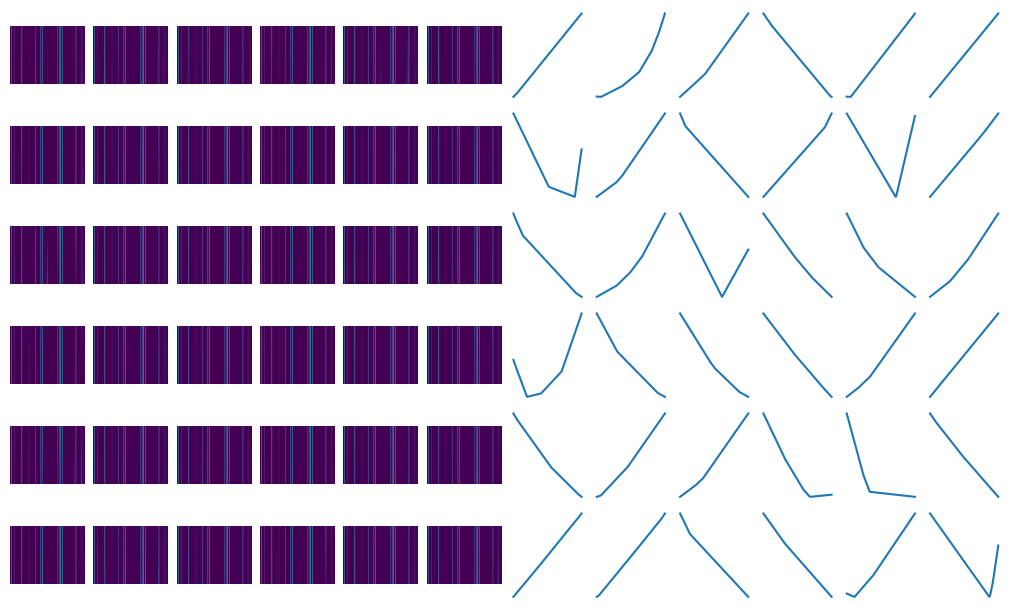

In [ ]:
# So here goes again, with the grid pattern of input pixels
# But this time using feature_strengths to scale the output features
model = mnist_model
layer = model.get_layer(index=1)
values = np.linspace(min_value, max_value, 100)
results = list()
for x in range(0,28,5):
  for y in range(0,28,5):
    #print(f"({x},{y}) -> {y*28+x}")
    #(c, a, _) = get_output_curve(layer, y*28+x, values, default_value, node_scaling=feature_strengths)
    (c, a, _) = get_output_curve(layer, y*28+x, values, default_values.reshape(-1), node_scaling=feature_strengths)
    results.append({
        "x": x,
        "y": y,
        "c": c,
        "a": a
    })

fig = plt.figure(figsize=(10,6), layout='constrained')
axs = fig.subplots(6,12)
for row in range(6):
  for col in range(6):
    idx = row*6+col
    res = results[idx]
    axs[row,col].imshow(res["a"])
    axs[row,col].set_axis_off()
    axs[row,col+6].plot(values, res["c"])
    axs[row,col+6].set_axis_off()

This produces _slightly_ different results than before.

Still, I think so far, as far as automated/default set of parameters go, I'd select:
* Use per-input-feature/per-pixel means for static input values rather than a global mean.
* Scale layer outputs by their mean strength into the next layer.
* Pick k-top input-features/pixels based on their estimated impact on final outcome when automatically selecting a subset of input features/pixels to examine.

Let's now look at what happens if we vary all input features/pixels in concert, instead of holding all static except for the one that we are varying.
This calls for a somewhat different approach to the input args, so I'll create a separate function for now and merge them later.

In [ ]:
def get_output_curve2(layer, mins, maxs, steps, **kwargs):
  """
  Computes the output activations and summed curve for a range of input values.
  Input values are varies across all input features in tandem, but according to their respective range from test data.
  Args:
    layer                  : assumed to be a Dense layer
    mins (ndarray(n,))     : min value for each of n input features
    maxs (ndarray(n,))     : max value for each of n input features
    steps (scalar int)     : number of step changes in value to simulate
  Keyword args:
    node_scaling (ndarray (j,)): relative importance of each node's output,
                                 used to calculate the curve via a weighted sum instead of an equal sum
  Returns
    curve       (ndarray (v,))
    activations (ndarray (v,j)) : activations from each node in the layer (j nodes)
  """
  if not isinstance(layer, tf.keras.layers.Dense):
    raise Exception(f"Not a supported layer type: {type(layer)}")
  if not np.isscalar(coord):
    raise Exception(f"Coord must be an integer scalar")

  weights = layer.variables[0].numpy()
  bias    = layer.variables[1].numpy()
  in_width  = weights.shape[0]
  out_width = weights.shape[1]
  #print(f"weights shape: {weights.shape}")
  #print(f"bias    shape: {bias.shape}")

  node_scaling = kwargs.get('node_scaling', np.repeat(1., out_width))

  if coord < 0 or coord >= in_width:
    raise Exception(f"Coord must be in range [0,{in_width}): {coord}")
  if mins.shape != (in_width,):
    raise Exception(f"mins must have shape ({in_width},): {mins.shape}")
  if maxs.shape != (in_width,):
    raise Exception(f"maxs must have shape ({in_width},): {maxs.shape}")
  if node_scaling.shape != (out_width,):
    raise Exception(f"node_scaling must have shape ({out_width},): {node_scaling.shape}")

  mins = mins.reshape(1,-1)
  maxs = maxs.reshape(1,-1)
  values = np.linspace(0.0, 1.0, steps).reshape(-1,1);
  input = values * (maxs - mins) + mins

  outputs = np.matmul(input, weights) + bias
  outputs = np.maximum(0, outputs)              # TODO apply activation function from layer config
  outputs = outputs * node_scaling
  curve = np.sum(outputs, axis=1)
  #print(f"activation.shape: {outputs.shape}")
  #print(f"curve.shape:      {value.shape}")

  return (curve, outputs, input)

In [ ]:
min_value

0.0

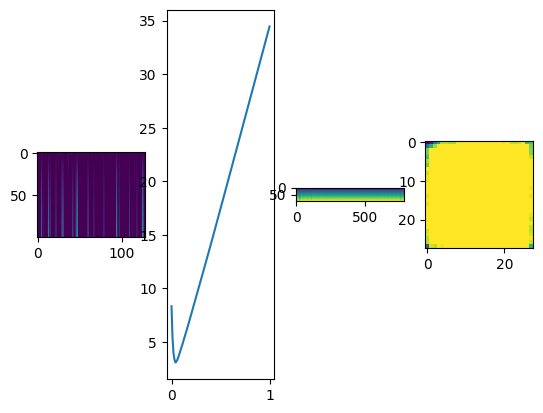

In [ ]:
# Now plot with each input pixel varied at the same time in concert, and with node scaling
# Unfortunately, unlike the previous cases, you only get one representative curve here.
(c, a, inp) = get_output_curve2(model.get_layer("dense"), min_values.reshape(-1), max_values.reshape(-1), 100, node_scaling=feature_strengths)

plt.figure()
plt.subplot(1,4,1)
plt.imshow(a)
plt.subplot(1,4,2)
plt.plot(v, c)
plt.subplot(1,4,3)
plt.imshow(inp)
plt.subplot(1,4,4)
plt.imshow(inp[1].reshape(28,28))

Learnings:
* This was basically a waste of time, because it just gives a single averaged plot across the entire set of weights. There's not really much in that.

# Complex Curve Fitting
Now for something more direct. Let's train a network against a sinusoidal with a single hidden layer of 128 units, and a single output node. It's almost a given that the hidden layer would correspond to constructing a piecewise curve.

One thing we'd expect is that the 128 units would train to spread their usage across the curve in the range that it's trained on. Outside of that range there should be no close piecewise fits. Rather, the very first and last of the 128 units should simply extend their linear fit towards negative and positive infinity, respectively.

So we'd expect to see a straight line fit outside of the trained range.

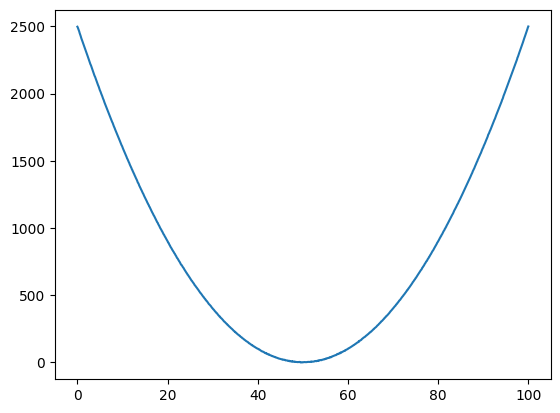

In [ ]:
# Define curve to fit
x = np.linspace(0.0, 100.0, 1000)
#y = np.sin(x/100.0 * np.pi * 5)
y = (x-50)**2 + np.random.normal(size=(1000,))
plt.plot(x,y)

In [ ]:
# WIP
# Let's see what happens if we pre-compute the ideal weights and biases by splitting the curve into 128 discrete segments
#def calculate_ideal(x, y, units)
#  return (weights, biases)
#
#calculate_ideal(x, y, 128)

In [ ]:
# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
#opt = 'adam'
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
model.fit(x, y, epochs=1000, batch_size=len(x))
# note: this produces lots of output, which I'll clear afterwards

In [ ]:
quadratic_model = model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               256       
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


32/32 [==============================] - 0s 1ms/step


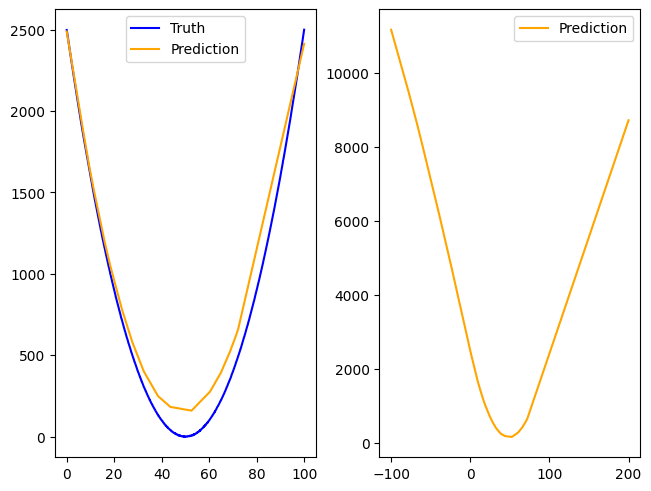

In [ ]:
# Plot prediction and ground-truth
y_predict = model.predict(x)
x_wide = np.linspace(-100, 200, 1000)
y_wide_predict = model.predict(x_wide)
plt.figure(layout='constrained')
plt.subplot(1,2,1)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange',label="Prediction")
plt.legend()
plt.subplot(1,2,2)
plt.plot(x_wide,y_wide_predict, color='orange', label="Prediction")
plt.legend()


Notice that we do indeed get the extended lines beyond on the training data.

weight shape: (1, 128)
biases shape: (128,)


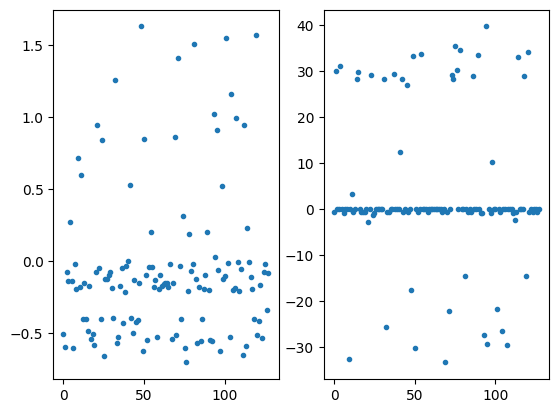

In [ ]:
weights = model.get_layer(index=0).variables[0].numpy()
biases = model.get_layer(index=0).variables[1].numpy()
print(f"weight shape: {weights.shape}")
print(f"biases shape: {biases.shape}")
plt.subplot(1,2,1)
plt.plot(weights.reshape((-1,)), marker='.', linestyle='None')
plt.subplot(1,2,2)
plt.plot(biases, marker='.', linestyle='None')

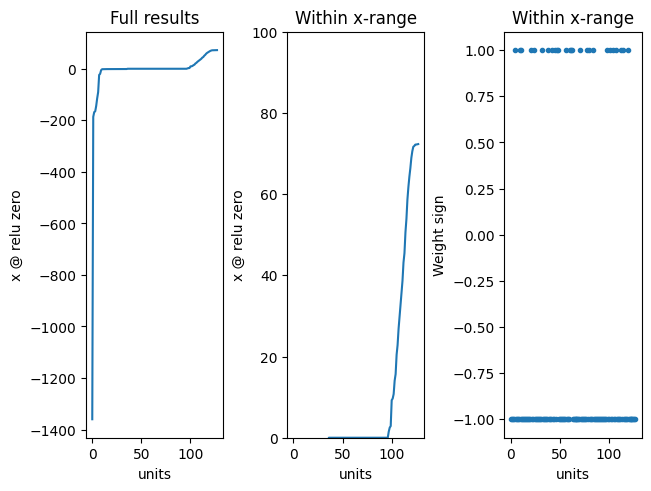

In [ ]:
# Let's plot the ordered zero-points of each of these ReLu units
# output = w*x + b = 0 when: x = -b / w
zero_points = -biases / weights.reshape(-1,)
zero_points = np.sort(zero_points)
zero_point_weights = weights.reshape(-1,)[np.argsort(zero_points)]
plt.figure(layout='constrained')
plt.subplot(1,3,1)
plt.plot(zero_points)
plt.title('Full results')
plt.ylabel('x @ relu zero')
plt.xlabel('units')
plt.subplot(1,3,2)
plt.plot(zero_points)
plt.ylim(0.0, 100.0)
plt.title('Within x-range')
plt.ylabel('x @ relu zero')
plt.xlabel('units')
plt.subplot(1,3,3)
plt.plot(np.sign(zero_point_weights), marker='.', linestyle='None')
plt.title('Within x-range')
plt.ylabel('Weight sign')
plt.xlabel('units')
plt.show()

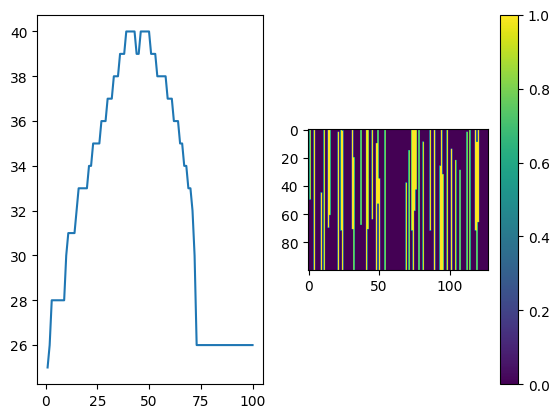

In [ ]:
# Let's look at this differently and consider how many of the 128 nodes are "active" against different values of x.
# Given that they're just linear combinations of the single input feature, if they're all active most of the time then all we'd get is a straight line with slope equal to the average weight.
x_sample = np.linspace(1.0, 100.0, 100).reshape((-1, 1))
out = np.matmul(x_sample, weights) + biases
active_units = np.sum(out > 0,1)
plt.subplot(1,2,1)
plt.plot(x_sample, active_units)
plt.subplot(1,2,2)
plt.imshow(out > 0)
plt.colorbar()

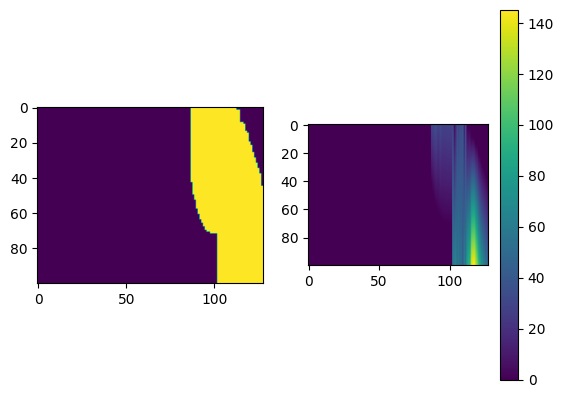

In [ ]:
# The image view is looking quite informative. Let's sort its columns (units) based on when they become active.
# Sort order:
#  - never active first
#  - then earlier starts before later starts
#  - then earlier ends before later ends
starts=np.argmax(out > 0, axis=0)
# make starts negative for units that never become active
starts[np.max(out > 0, axis=0) == False] = -1
ends=(x.shape[0]-1) - np.argmax(np.flip(out, axis=0) > 0, axis=0)

# using stable sort, do multiple times, in reverse order of importance
indices = np.argsort(ends, kind='stable')
starts = starts[indices]
out_sorted = out[:,indices]
indices = np.argsort(starts, kind='stable')
out_sorted = out_sorted[:,indices]

# Plot
plt.subplot(1,2,1)
plt.imshow(out_sorted > 0)
plt.subplot(1,2,2)
plt.imshow(np.maximum(0, out_sorted))
plt.colorbar()

Let's wrap up what we've got so far into some helper functions so we can apply them against different models.

Useful things:
* Summed activations the "curve interpretation"
* Number of active units
* Sorted images showing activation of units

For inspiration, we want a flexible and easy to use API:
```python
layer = model.get_layer(index=0)
x_sample = fill_input(layer, np.linspace(0, 100, 0.1))          # smart defaults
x_sample = fill_input(layer, np.linspace(0, 100, 0.1), coord=(2,), defaults=0.3)
x_sample = fill_input(layer, np.linspace(0, 100, 0.1), coord=(2,), defaults=np.array([0.3, 0.4, 0.5, 0.6, -1.3]))
plot_unit_activation(model, x_sample)                           # smart defaults
plot_unit_activation(model, layer=layer, x_sample)
plot_unit_activation(model, layer_index=0, x_sample)
plot_unit_activation(model, layer_name='dense_5', x_sample)
info = get_unit_activation(model, layer, x_sample)              # the same data that plot_unit_activation works off
```

Showing results for layer: dense_10 (index 0)


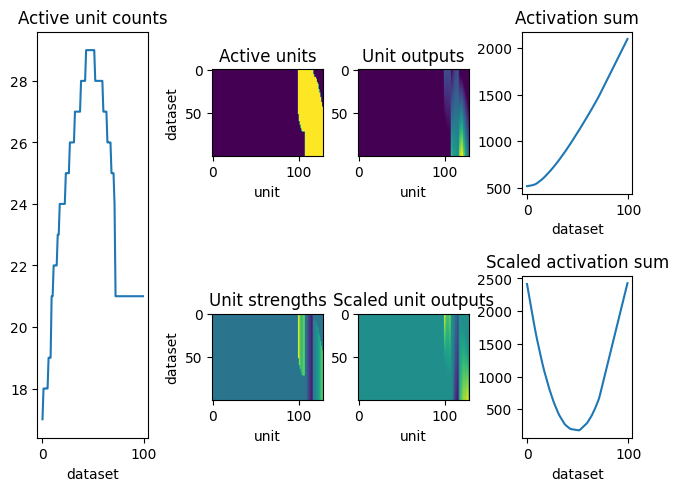

In [ ]:
def get_layer_index_by_name(model, name):
  for (idx, layer) in enumerate(model.layers):
    if layer.name == name:
      return idx;
  layers = ", ".join([layer.name for layer in model.layers])
  raise ValueError(f"No layer with name '{name}' in layers: {layers}")

def fill_input(layer, values = np.linspace(0.0, 1.0, 100), **kwargs):
  """
  Constructs an input tensor for the identified layer, by populating it with
  values from the provided array.
  Args:
    values (ndarray (v,))  : values across single column (defaults to a 100 values from 0.0 to 1.0)
  Keword Args:
    coord (int)            : coordinate to apply values, according to input shape of layer (default: 0)
    default (scalar or ndarray (n,)) :
                             default value or values for all input cells (n inputs).
                             Either a scalar, or an array of same size as layer's input vector.
  Returns
    data        (ndarray (v,n)) : input data for layer with v samples across n features
  """
  if not isinstance(layer, tf.keras.layers.Dense):
    raise Exception(f"Not a supported layer type: {type(layer)}")

  coord = kwargs.get('coord', 0);
  defaults = kwargs.get('defaults', 0.0);

  weights = layer.variables[0].numpy()
  bias    = layer.variables[1].numpy()
  in_width  = weights.shape[0]
  out_width = weights.shape[1]

  if not np.isscalar(coord):
    raise Exception(f"Coord must be an integer scalar")
  if coord < 0 or coord >= in_width:
    raise Exception(f"Coord must be in range [0,{in_width}): {coord}")
  if not np.isscalar(defaults) and defaults.shape != (in_width,):
    raise Exception(f"defaults must be either scalar or have shape ({in_width},): {defaults.shape}")

  data = np.full((len(values), in_width), defaults)
  data[:,coord] = values
  return data

def argsort_by_activation(out):
  """
  Returns the sort indices by unit activation, in order for producing more interpretable
  images.
  Units are considered active if the output value is > 0.0.

  Sorts according to this order:
   - never active first
   - within never active:
     - then lowest value at start
     - then highest value at end
   - within active:
     - then earlier starts before later starts
     - then earlier ends before later ends

  Args:
    out    (ndarray (r,c)) : output from layer
  Returns:
    indices (ndarray (c,)) : indices for sorting columns by
  """

  # target indices to shuffle
  target = np.array(range(0, out.shape[1]))

  activations = out > 0.0
  starts=np.argmax(activations, axis=0)
  starts[np.max(activations, axis=0) == False] = -1
  ends=(out.shape[0]-1) - np.argmax(np.flip(activations, axis=0), axis=0)
  start_values=out[0,:]
  end_values=out[-1,:]
  direction=np.sign(end_values - start_values)

  # using stable sort, do multiple times, in reverse order of importance
  # - least important step: increasing end_values
  indices = np.argsort(end_values, kind='stable')
  start_values = start_values[indices]
  direction = direction[indices]
  ends = ends[indices]
  starts = starts[indices]
  target = target[indices]
  # - next step: increasing start_values
  indices = np.argsort(start_values, kind='stable')
  direction = direction[indices]
  ends = ends[indices]
  starts = starts[indices]
  target = target[indices]
  # - next step: group by direction
  indices = np.argsort(direction, kind='stable')
  ends = ends[indices]
  starts = starts[indices]
  target = target[indices]
  # - next step: increasing activation ends
  indices = np.argsort(ends, kind='stable')
  starts = starts[indices]
  target = target[indices]
  # - most important step: increasing activation starts
  indices = np.argsort(starts, kind='stable')
  target = target[indices]
  return target

def sort_by_activation(out, **kwargs):
  """
  Sorts a layer output matrix by unit activation, in order for producing more interpretable
  images.
  Units are considered active if the output value is > 0.0.
  By default applies the sort to the provided output data, but optionally
  applies it to the columns of 'target'.

  Sorts according to this order:
   - never active first
   - within never active:
     - then lowest value at start
     - then highest value at end
   - within active:
     - then earlier starts before later starts
     - then earlier ends before later ends

  Args:
    out    (ndarray (r,c)) : output from layer
  Keyword args:
    target (ndarray (r,c)) : optional apply sorting to this instead
  Returns:
    sorted (ndarray (r,c))  : 'out' or 'target' with order of columns sorted
  """

  target = kwargs.get('target', out)
  indices = argsort_by_activation(out)
  return target[:,indices]

def get_unit_activation(model, x, **kwargs):
  """
  Args:
    model                  - the model
    x     (ndarray(v,n))   - input data, v samples of n features
  Keyword args:
    layer               - the actual layer, defaults to first
    layer_index (int)   - index of layer to examine, defaults to first
    layer_name (string) - name of layer to examine, defaults to first
    sort (boolean)      - whether to sort returned activations etc. (default: True)
  Return:
    dict, with:
      activations           (ndarray(v,n)) - unit activations across input data
                                             (sorted by sort_indices, unless disabled)
      activation_sum        (ndarray(v,))  - sum of activations by input data
      scaled_activations    (ndarray(v,n)) - activations scaled by unit_strengths,
                                             or 'None' if not available
                                             (sorted by sort_indices, unless disabled)
      scaled_activation_sum (ndarray(v,))  - sum of activations scaled by unit_strengths,
                                             or 'None' if not available
      unit_strengths        (ndarray(n,))  - unit effective strengths according to mean weights in next layer,
                                             or 'None' if not available
                                             (sorted by sort_indices, unless disabled)
      sort_indices          (ndarray(n,))  - array of indices used for ordering columns for easiest visualisation
  """

  # General config
  layer = kwargs.get('layer')
  layer_index = kwargs.get('layer_index', 0)
  sort = kwargs.get('sort', True)

  # Get layers
  next_layer = None
  if layer:
    layer_index = model.layers.index(layer)
  elif 'layer_name' in kwargs:
    layer_index = get_layer_index_by_name(model, kwargs['layer_name'])
  if layer is None:
    layer = model.get_layer(index=layer_index)
  if (layer_index+1) < len(model.layers):
    next_layer = model.get_layer(index=layer_index+1)
  if not isinstance(layer, tf.keras.layers.Dense):
    raise Exception(f"Not a supported layer type: {type(layer)}")

  # Inspect layer
  print(f"Showing results for layer: {layer.name} (index {layer_index})")
  weights = layer.variables[0].numpy()
  biases = layer.variables[1].numpy()
  in_width  = weights.shape[0]
  out_width = weights.shape[1]

  x_shape = (None,) + x.shape[1:]
  if x_shape != (None,in_width):
    raise Exception(f"x must have shape {(None,in_width)}: {x_shape}")

  # Compute layer outputs
  activations = np.maximum(0, np.matmul(x, weights) + biases)
  activation_sum = np.sum(activations, axis=1)
  active_counts = np.sum(activations > 0, axis=1)

  # Get adjustments from next layer
  unit_strengths = None
  scaled_activations = None
  scaled_activation_sum = None
  if next_layer is not None:
    next_weights = next_layer.variables[0].numpy()
    unit_strengths = np.mean(next_weights, axis=1)
    scaled_activations = activations * unit_strengths
    scaled_activation_sum = np.sum(scaled_activations, axis=1)

  # Apply sorting
  sort_indices = argsort_by_activation(activations)
  if sort:
    activations = activations[:,sort_indices]
    if next_layer is not None:
      unit_strengths = unit_strengths[sort_indices]
      scaled_activations = scaled_activations[:,sort_indices]

  return {
      'active_counts': active_counts,
      'activations': activations,
      'activation_sum': activation_sum,
      'unit_strengths': unit_strengths,
      'scaled_activations': scaled_activations,
      'scaled_activation_sum': scaled_activation_sum,
      'sort_indices': sort_indices
  }

def plot_unit_activation(model, x, **kwargs):
  """
  Args:
    model                  - the model
    x     (ndarray(v,n))   - input data, v samples, of n features
  Keyword args:
    layer               - the actual layer, defaults to first
    layer_index (int)   - index of layer to examine, defaults to first
    layer_name (string) - name of layer to examine, defaults to first
  """

  # Get data
  kwargs['sort']=True
  dict = get_unit_activation(model, x, **kwargs)

  # Generate plots
  fig = plt.figure(layout='constrained')
  gs = fig.add_gridspec(2, 4)
  ax = fig.add_subplot(gs[:,0])
  ax.plot(dict['active_counts'])
  ax.set_title('Active unit counts')
  ax.set_xlabel('dataset')

  ax = fig.add_subplot(gs[0,1])
  ax.imshow(dict['activations'] > 0)
  ax.set_title('Active units')
  ax.set_ylabel('dataset')
  ax.set_xlabel('unit')

  ax = fig.add_subplot(gs[0,2])
  ax.imshow(dict['activations'])
  ax.set_title('Unit outputs')
  ax.set_xlabel('unit')

  ax = fig.add_subplot(gs[0,3])
  ax.plot(dict['activation_sum'])
  ax.set_title('Activation sum')
  ax.set_xlabel('dataset')

  if dict['unit_strengths'] is not None:
    ax = fig.add_subplot(gs[1,1])
    ax.imshow((dict['activations'] > 0) * dict['unit_strengths'])
    ax.set_title('Unit strengths')
    ax.set_ylabel('dataset')
    ax.set_xlabel('unit')

    ax = fig.add_subplot(gs[1,2])
    ax.imshow(dict['scaled_activations'])
    ax.set_title('Scaled unit outputs')
    ax.set_xlabel('unit')

    ax = fig.add_subplot(gs[1,3])
    ax.plot(dict['scaled_activation_sum'])
    ax.set_title('Scaled activation sum')
    ax.set_xlabel('dataset')

model = quadratic_model
plot_unit_activation(model, layer_index=0, x=np.linspace(1.0, 100.0, 100).reshape((-1, 1)))

Let's quickly check this against different models.

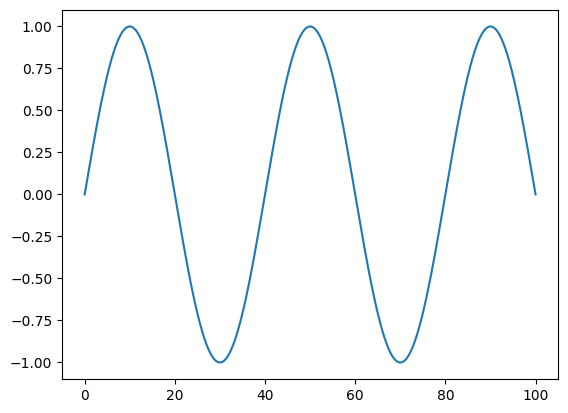

In [ ]:
# Sinusoidal model
x = np.linspace(0.0, 100.0, 1000)
y = np.sin(x/100.0 * np.pi * 5)
plt.plot(x,y)

In [ ]:
idx = np.random.permutation(len(x))
x_train = x[idx]
y_train = y[idx]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
history = model.fit(x_train, y_train, epochs=10000, batch_size=len(x_train), verbose=0, callbacks = [LessVerboseEpochLogger(500)])
sinusoidal_model = model

Epoch   500: loss: 0.4833  mse: 0.4833  
Epoch  1000: loss: 0.4833  mse: 0.4833  
Epoch  1500: loss: 0.4833  mse: 0.4833  
Epoch  2000: loss: 0.4833  mse: 0.4833  
Epoch  2500: loss: 0.4833  mse: 0.4833  
Epoch  3000: loss: 0.4833  mse: 0.4833  
Epoch  3500: loss: 0.4833  mse: 0.4833  
Epoch  4000: loss: 0.4805  mse: 0.4805  
Epoch  4500: loss: 0.3620  mse: 0.3620  
Epoch  5000: loss: 0.3426  mse: 0.3426  
Epoch  5500: loss: 0.3389  mse: 0.3389  
Epoch  6000: loss: 0.3238  mse: 0.3238  
Epoch  6500: loss: 0.2963  mse: 0.2963  
Epoch  7000: loss: 0.2847  mse: 0.2847  
Epoch  7500: loss: 0.2808  mse: 0.2808  
Epoch  8000: loss: 0.2785  mse: 0.2785  
Epoch  8500: loss: 0.2470  mse: 0.2470  
Epoch  9000: loss: 0.1392  mse: 0.1392  
Epoch  9500: loss: 0.0900  mse: 0.0900  
Epoch 10000: loss: 0.0752  mse: 0.0752  


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               256       
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 1ms/step


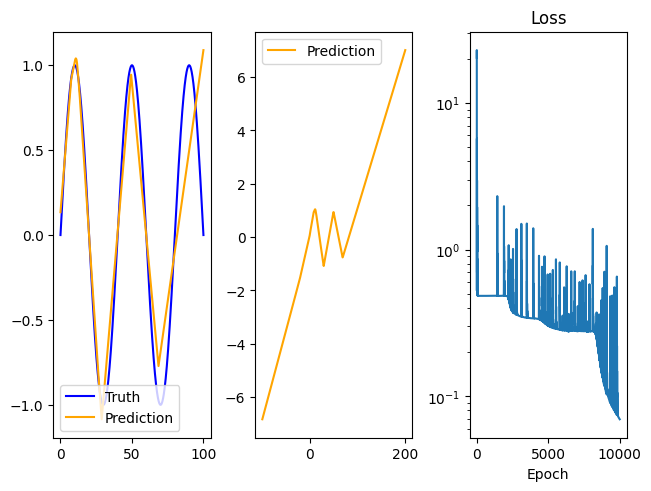

In [ ]:
model = sinusoidal_model
model.summary()
plot_fit(model, x, history)

Showing results for layer: dense_10 (index 0)


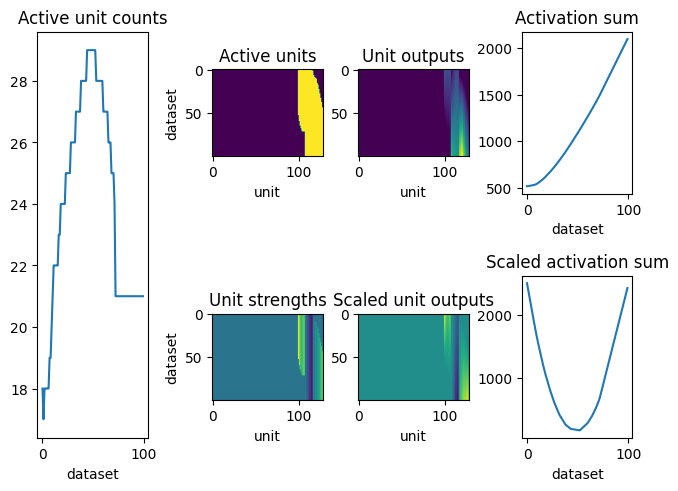

In [ ]:
plot_unit_activation(quadratic_model, layer_index=0, x=np.linspace(0.0, 100.0, 100).reshape((-1, 1)))

Showing results for layer: dense_32 (index 0)


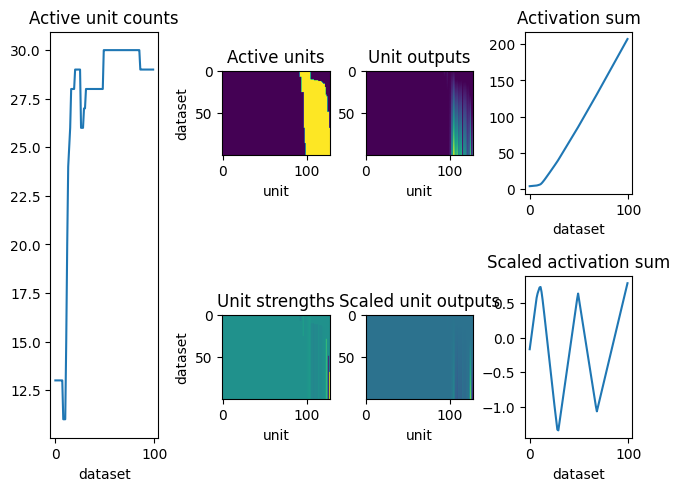

In [ ]:
plot_unit_activation(sinusoidal_model, layer_index=0, x=np.linspace(0.0, 100.0, 100).reshape((-1, 1)))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               100480    
                                                                 
 dense_35 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Showing results for layer: dense_34 (index 1)


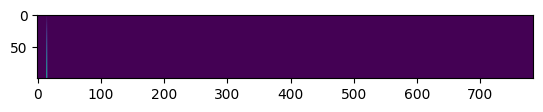

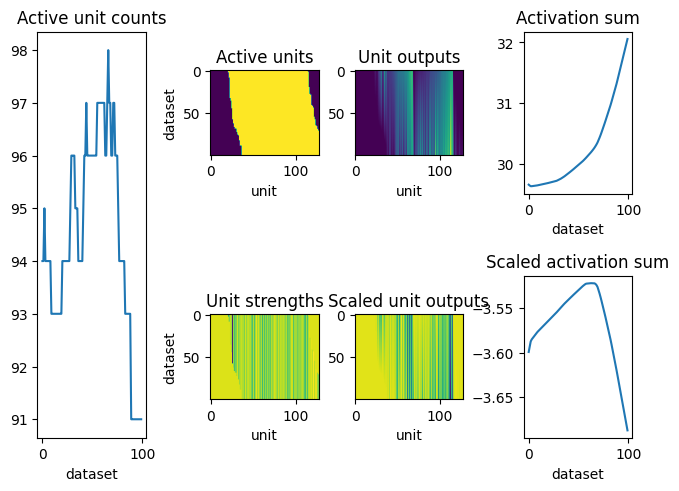

In [ ]:
mnist_model.summary()
coord=0*28 + 15 # (x=15,y=0)
layer = mnist_model.get_layer(index=1)
x_sample = fill_input(layer, np.linspace(0.0, 1.0, 100), coord=coord)
plt.imshow(x_sample)
plot_unit_activation(mnist_model, x_sample, layer=layer, sort=False)

## Learnings

Training problems:
* I've had quite a lot of difficulty in training against the sinusoidal dataset. Something that in theory a ReLu layer should be able to model easily, but turns out to be very hard to train. See `Difficult to train v1` for further experiments.
* I think in the end the explanation for this problem is quite clear and comes down to the linear nature of ReLu, but also highlights problems in the training algorithm itself.
* With ReLu, when most units are active across the training data set, there's minimal differentiation between units as to their relative effect against the output (the only differentiation being their relative weights, which all tend to sit around 0.0). Consequently, they're all trying to optimise against the loss at the same time. Furthermore, because the loss is applied across the entire width of the curve in question, each unit is trying to optimise against the entire curve - and of course a single unit is optimised in that case by fitting a straight line to the mid point of the curve.
* The reason why we see sudden improvements is likely that one or more units has slowly creaped towards a point where it suddenly is better to fit against one less curve peak, and then it quickly optimises to fitting just that sub-section of the curve.

Training solutions:
* For this particular case, a solution may lie in a form of weight regularization. The observation is that we have problems when all units are active at the same time. So we'd like to regularize the units so that they tend to be active at different times. This can be conceived of as what I've been calling the "zero-point" of the Relu curve, or the inflection point in its curve.
* We'd like that the zero-points are distributed across the range of input data.
* At a first step, we want to ensure that most units have a zero-point _within_ the range of the dataset - rather than simply always inactive or always active.
This could be achieved by a loss function that tries to pull the zero points in towards the mid-point.
* Or better yet, some sort of correlation measure that encourages a _spread_ of zero points across the range of the dataset.

Applicability:
* The problems faced here with something like 30% or more of units always inactive is likely to afflict all networks. It's a reason why the LeakyReLu was invented. Fundamentally the problem is that once the activation is zero for all data, then it never receives any updates. LeakReLu solves that by always being a little bit active. But it's kind of a hack.
* Perhaps a better solution is the zero-point regularization suggested above.
* It'd be interesting to see what other solutions the research community have come up with to solve permanentaly inactive Relu units.
* However, the problem is probably only obvious in my use case because each unit has only a single input. For something like image processing, each unit receives many inputs, and so there is a far greater likelihood of being active for some portion of the training dataset.
* It'd be interesting to produce the "active units" plot for something like an image classification problem. I expect that I'll see a far greater variation of when units are active, and that all units will be active at some point.

Improvements to visualisation:
* It occurred to me that I don't need to bother with generating simulated data sets. I can generate my visualisations from raw training data. For my curves, the training data is already exactly of the form I want. For larger problems, like image classification, I might want to sample a random selection of the training data so that the visualisation images are still more or less square.
* The other problem is that the training data set won't produced ordered outputs. But for problem domaisn like image classification, there's no such thing as an order anyway. So that's ok. I think I'd just want to apply a similar sorting logic on the vertical axis in order to improve the smoothness of the results.